# Data Augmentation for brain tumor segmentation

## Qimin Zhang and Weiwei Qi

## 1. Config

In [61]:
import os
import copy
import enum
from time import time
import random
import warnings
import tempfile
import subprocess
import multiprocessing
from pathlib import Path

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import Compose
from torchvision.utils import make_grid, save_image
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from glob import glob
import pickle
warnings.filterwarnings('ignore')

import torchio
from torchio import AFFINE, DATA, PATH, TYPE, STEM

from torch.utils.data import Dataset, SubsetRandomSampler

import numpy as np
import nibabel as nib
from scipy import stats
import SimpleITK as sitk
import matplotlib.pyplot as plt

from IPython import display
from tqdm.notebook import tqdm

print('TorchIO version:', torchio.__version__)

training_split_ratio = 0.9
num_epochs = 5
compute_histograms = False
train_whole_images = False
train_patches = False

seed = 4460
torch.manual_seed(4460)
np.random.seed(4460)

TorchIO version: 0.14.1


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Computation Details')
print(f'\tDevice Used: ({device})  {torch.cuda.get_device_name(torch.cuda.current_device())}\n')

print('Packages Used Versions:-')
print(f'\tPytorch Version: {torch.__version__}')

Computation Details
	Device Used: (cuda)  Tesla K80

Packages Used Versions:-
	Pytorch Version: 1.4.0


## 2. Train a U-Net with original data

In [90]:
# Dataset folder used
DATASET_PATH = os.path.join('./data')

# We would like to perform a train-validation-test split at the ratio of T:V:T = 6:2:2.
VAL_SPLIT = 0.1
TEST_SPLIT = 0.1

# Batch size for training. Limited by GPU memory
BATCH_SIZE = 6
# Training Epochs
epochs = 80

In [71]:
print(sorted(glob("./data/all_gbm_pre_reg/*_t1reg.nii.gz"))[0])
print(sorted(glob("./data/all_tumors_reg/*_seg_reg.nii.gz"))[0])

./data/all_gbm_pre_reg/BraTS19_2013_0_1_t1reg.nii.gz
./data/all_tumors_reg/BraTS19_2013_0_1_seg_reg.nii.gz


In [91]:
class TumorDataset(Dataset):
    '''
    Returns a TumorDataset class object which represents our tumor dataset.
    TumorDataset inherits from torch.utils.data.Dataset class.
    '''

    def __init__(self, root_dir, DEBUG = False):
        '''
        Constructor for our TumorDataset class.
        Parameters:
            root_dir(str): Directory with all the images.
            DEBUG(bool): To switch to debug mode for image transformation.

        Returns: None
        '''
        self.root_dir = root_dir
        # The default transformation is composed of 
        # 1) a grayscale conversion.
        self.default_transformation = transforms.Compose([
            transforms.Grayscale()
        ])
        self.DEBUG = DEBUG

    def __getitem__(self, index):
        '''
        Overridden method from inheritted class to support
        indexing of dataset such that datset[I] can be used
        to get Ith sample.
        Parameters:
            index(int): Index of the dataset sample
            
        Return:
            sample(dict): Contains the index, image, mask torch.Tensor.
                        'index': Index of the image.
                        'image': Contains the tumor image torch.Tensor.
                        'mask' : Contains the mask image torch.Tensor.
        '''
        # Find the filenames for the tumor images and masks.
        image_path = os.path.join(self.root_dir, "all_gbm_pre_reg")
        tumor_path = os.path.join(self.root_dir, "all_tumors_reg")
        
        image_name = sorted(glob(os.path.join(image_path, "*t1reg.nii.gz")))[index]
        mask_name = sorted(glob(os.path.join(tumor_path, "*seg_reg.nii.gz")))[index]

        # Use nibabel to open the images and masks.
        image = nib.load(image_name).get_fdata()
        mask = nib.load(mask_name).get_fdata()

        # Apply the default transformations on the images and masks.
        #image = self.default_transformation(image)
        #mask = self.default_transformation(mask)

        # Convert the images and masks to tensor.
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        
        # Construct the images and masks together in the form of a dictionary.
        sample = {'index': index, 'image': image, 'mask': mask}
        return sample

    def __len__(self):
        '''Overridden method from inheritted class so that
        len(self) returns the size of the dataset.
        '''
        error_msg = 'Part of dataset is missing!\nNumber of tumor and mask images are not same.'
        total_image_files = len(glob(os.path.join(self.root_dir, 'all_gbm_pre_reg', '*t1reg.nii.gz')))
        total_tumor_files = len(glob(os.path.join(self.root_dir, 'all_tumors_reg', '*seg_reg.nii.gz')))

        # Sanity check: the number of files shall be even since tumor images and masks are in pairs.
        assert total_image_files == total_tumor_files, error_msg
        
        # Return how many image-mask pairs we have.
        return total_image_files

In [92]:
def get_indices(length, val_split, test_split):
    '''
    Gets the Training & Testing data indices for the dataset.
    Stores the indices and returns them back when the same dataset is used.
    Inputs:
        length(int): Length of the dataset used.
        val_split: the portion (0 to 1) of data used for validation.
        test_split: the portion (0 to 1) of data used for testing.
    Parameters:
        train_indices(list): Array of indices used for training purpose.
        validation_indices(list): Array of indices used for validation purpose.
        test_indices(list): Array of indices used for testing purpose.
    '''
    data = dict()
    indices = list(range(length))
    np.random.shuffle(indices)
    split1 = int(np.floor(test_split * len(tumor_dataset)))
    split2 = split1 + int(np.floor(val_split * len(tumor_dataset)))
    train_indices, validation_indices, test_indices = indices[split2:], indices[split1:split2], indices[:split1]
    return train_indices, validation_indices, test_indices

In [93]:
tumor_dataset = TumorDataset(DATASET_PATH)

train_indices, validation_indices, test_indices = get_indices(len(tumor_dataset), val_split = VAL_SPLIT, test_split = TEST_SPLIT)
train_sampler, validation_sampler, test_sampler = SubsetRandomSampler(train_indices), SubsetRandomSampler(validation_indices), SubsetRandomSampler(test_indices)

trainloader = torch.utils.data.DataLoader(tumor_dataset, BATCH_SIZE, sampler = train_sampler)
validationloader = torch.utils.data.DataLoader(tumor_dataset, 1, sampler = validation_sampler)
testloader = torch.utils.data.DataLoader(tumor_dataset, 1, sampler = test_sampler)

print('Number of files in the train set: %s \nNumber of files in the validation set: %s \nNumber of files in the test set: %s' \
      % (len(train_indices), len(validation_indices), len(test_indices)))

Number of files in the train set: 269 
Number of files in the validation set: 33 
Number of files in the test set: 33


In [75]:
print(tumor_dataset.__getitem__(0)['image'].size())
print(tumor_dataset.__getitem__(0)['mask'].size())

torch.Size([155, 240, 240])
torch.Size([155, 240, 240])


In [94]:
class conv_block(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(conv_block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size = 3, stride = 1, padding = 1, bias = True),
            nn.ReLU(inplace = True),
            nn.Conv2d(ch_out, ch_out, kernel_size = 3, stride = 1, padding = 1, bias = True),
            nn.ReLU(inplace = True)
        )

    def forward(self,x):
        x = self.conv(x)
        return x

class up_conv(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor = 2),
            nn.Conv2d(ch_in, ch_out, kernel_size = 3, stride = 1, padding = 1, bias = True),
            nn.ReLU(inplace = True)
        )

    def forward(self,x):
        x = self.up(x)
        return x
    
class U_Net(nn.Module):
    '''
    This is the Pytorch version of U-Net Architecture.

    The input and output of this network is of the same shape.
    Input Size of Network - (155,240,240). 
        Note that the input size here is just for our dataset in this notebook, but if you use this network for other projects, any input size that is a multiple of 2 ** 5 will work.
    Output Size of Network - (155,240,240).
        Shape Format :  (Channel, Width, Height)
    '''
    def __init__(self, img_ch = 155, output_ch = 155, first_layer_numKernel = 256):
        '''
        Constructor for UNet class.
        Parameters:
            img_ch(int): Input channels for the network. Default: 1
            output_ch(int): Output channels for the final network. Default: 1
            first_layer_numKernel(int): Number of kernels uses in the first layer of our unet.
        '''
        super(U_Net, self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.Conv1 = conv_block(ch_in = img_ch, ch_out = first_layer_numKernel)
        self.Conv2 = conv_block(ch_in = first_layer_numKernel, ch_out = 2 * first_layer_numKernel)
        self.Conv3 = conv_block(ch_in = 2 * first_layer_numKernel, ch_out = 4 * first_layer_numKernel)
        self.Conv4 = conv_block(ch_in = 4 * first_layer_numKernel, ch_out = 8 * first_layer_numKernel)
        self.Conv5 = conv_block(ch_in = 8 * first_layer_numKernel, ch_out = 16 * first_layer_numKernel)

        self.Up5 = up_conv(ch_in = 16 * first_layer_numKernel, ch_out = 8 * first_layer_numKernel)
        self.Up_conv5 = conv_block(ch_in = 16 * first_layer_numKernel, ch_out = 8 * first_layer_numKernel)

        self.Up4 = up_conv(ch_in = 8 * first_layer_numKernel, ch_out = 4 * first_layer_numKernel)
        self.Up_conv4 = conv_block(ch_in = 8 * first_layer_numKernel, ch_out = 4 * first_layer_numKernel)
        self.Up3 = up_conv(ch_in = 4 * first_layer_numKernel, ch_out = 2 * first_layer_numKernel)
        self.Up_conv3 = conv_block(ch_in = 4 * first_layer_numKernel, ch_out = 2 * first_layer_numKernel)
        
        self.Up2 = up_conv(ch_in = 2 * first_layer_numKernel, ch_out = first_layer_numKernel)
        self.Up_conv2 = conv_block(ch_in = 2 * first_layer_numKernel, ch_out = first_layer_numKernel)

        self.Conv_1x1 = nn.Conv2d(first_layer_numKernel, output_ch, kernel_size = 1, stride = 1, padding = 0)

    def forward(self, x):
        '''
        Method for forward propagation in the network.
        Parameters:
            x(torch.Tensor): Input for the network of size (155, 240, 240).

        Returns:
            output(torch.Tensor): Output after the forward propagation 
                                    of network on the input.
        '''
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)
        
        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)
        
        # decoding + concat path
        d5 = self.Up5(x5)
        d5 = torch.cat((x4, d5), dim = 1)
        
        d5 = self.Up_conv5(d5)
        
        d4 = self.Up4(d5)
        d4 = torch.cat((x3, d4), dim = 1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2, d3), dim = 1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1, d2), dim = 1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)
        output = F.sigmoid(d1)

        return output

In [95]:
def dice_coefficient(predicted, target):
    '''
    Calculates the Sørensen–Dice Coefficient for a single sample.
    Parameters:
        predicted(numpy.ndarray): Predicted single output of the network.
                                Shape - (Channel, Height, Width)
        target(numpy.ndarray): Actual required single output for the network
                                Shape - (Channel, Height, Width)

    Returns:
        coefficient(float): Dice coefficient for the input sample.
                                    1 represents highest similarity and
                                    0 represents lowest similarity.
    '''
    # The smooth term is used to prevent division by zero.
    smooth = 1
    product = np.multiply(predicted, target)
    intersection = np.sum(product)
    coefficient = (2 * intersection + smooth) / (np.sum(predicted) + np.sum(target) + smooth)
    return coefficient

In [96]:
unet_classifier = None
criterion = nn.BCELoss()
learning_rate = 0.0001

#### If you want to see the training trend within each epoch, you can change mini_batch to a positive integer 
#### that is no larger than the number of batches per epoch.
mini_batch = False

# Define where to save the model parameters.
model_save_path = './saved_models/'
os.makedirs(model_save_path, exist_ok = True)

# New model is created.
unet_model = U_Net().to(device)

#### You can uncomment this to see the textual architecture of our U-Net.
#print(unet_model)

In [97]:
# Training session history data.
history = {'train_loss': list(), 'validation_loss': list()}

# For save best feature. Initial loss taken a very high value.
last_score = 0

# Optimizer used for training process. Adam Optimizer.
optimizer = optim.Adam(unet_model.parameters(), lr = learning_rate)

# Reducing LR on plateau feature to improve training.
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.85, patience = 2, verbose = True)

print('Starting Training Process')

assert validationloader.batch_size == 1

# Epoch Loop
for epoch in range(epochs):
    
    #################################### Train ####################################################
    unet_model.train()
    start_time = time()
    # Training a single epoch
    train_epoch_loss, train_batch_loss, batch_iteration = 0, 0, 0
    validation_score, validation_loss = 0, 0

    for batch, data in enumerate(trainloader):
        # Keeping track how many iteration is happening.
        batch_iteration += 1
        # Loading data to device used.
        image = data['image'].to(device, dtype=torch.float)
        mask = data['mask'].to(device, dtype=torch.float)
        # Clearing gradients of optimizer.
        optimizer.zero_grad()
        # Calculation predicted output using forward pass.
        output = unet_model(image)
        # Calculating the loss value.
        loss_value = criterion(output, mask)
        # Computing the gradients.
        loss_value.backward()
        # Optimizing the network parameters.
        optimizer.step()
        # Updating the running training loss
        train_epoch_loss += loss_value.item()
        train_batch_loss += loss_value.item()

        # Printing batch logs if any. Useful if you want to see the training trends within each epoch.
        if mini_batch:
            if (batch + 1) % mini_batch == 0:
                train_batch_loss = train_batch_loss / (mini_batch * trainloader.batch_size)
                print(
                    f'    Batch: {batch + 1:2d},\tBatch Loss: {train_batch_loss:.7f}')
                train_batch_loss = 0

    train_epoch_loss = train_epoch_loss / (batch_iteration * trainloader.batch_size)
    
    ################################### Validation ##################################################
    unet_model.eval()
    # To get data in loops.
    batch_iteration = 0

    for batch, data in enumerate(validationloader):
        # Keeping track how many iteration is happening.
        batch_iteration += 1
        # Data prepared to be given as input to model.
        image = data['image'].to(device, dtype=torch.float)
        mask = data['mask'].to(device, dtype=torch.float)

        # Predicted output from the input sample.
        mask_prediction = unet_model(image)
        
        # comput validation loss
        loss_value = criterion(mask_prediction, mask)
        validation_loss += loss_value.item()
        
        # Threshold elimination.
        mask_prediction = (mask_prediction > 0.5)
        mask_prediction = mask_prediction.cpu().numpy()
        mask = mask.cpu().numpy()

        mask = np.resize(mask, (155, 240, 240))
        mask_prediction = np.resize(mask_prediction, (155, 240, 240))
        # Calculate the dice score for original and predicted image mask.
        validation_score += dice_coefficient(mask_prediction, mask)

    # Calculating the mean score for the whole validation dataset.
    unet_val = validation_score / batch_iteration
    validation_loss = validation_loss / batch_iteration
    
    # Collecting all epoch loss values for future visualization.
    history['train_loss'].append(train_epoch_loss)
    history['validation_loss'].append(validation_loss)
    
    # Reduce LR On Plateau
    scheduler.step(validation_loss)

    time_taken = time() - start_time
    
    # Training Logs printed.
    print(f'Epoch: {epoch + 1:3d},  ', end = '')
    print(f'train Loss: {train_epoch_loss:.5f},  ', end = '')
    print(f'validation Loss: {validation_loss:.5f},  ', end = '')
    print(f'validation score: {unet_val:.5f},  ', end = '')

    for pg in optimizer.param_groups:
        print('current lr: ', pg['lr'], ', ', end = '')
    print(f'Time: {time_taken:.2f} s', end = '')

    # Save the model every epoch.
    current_epoch_model_save_path = os.path.join(model_save_path, 'Basic_Unet_epoch_%s.pth' % (str(epoch).zfill(3)))
    torch.save(unet_model.state_dict(), current_epoch_model_save_path)
    
    # Save the best model (determined by validation score) and give it a unique name.
    best_model_path = os.path.join(model_save_path, 'Basic_Unet_best_model.pth')
    if  last_score < unet_val:
        torch.save(unet_model.state_dict(), best_model_path)
        last_score = unet_val
        print(f'\tBest model saved at score: {unet_val:.5f}')
    else:
        print()

print(f'Training Finished after {epochs} epoches')

Starting Training Process
Epoch:   1,  train Loss: 0.09605,  validation Loss: 0.39224,  validation score: 0.08358,  current lr:  0.0001 , Time: 357.48 s	Best model saved at score: 0.08358
Epoch:   2,  train Loss: 0.02621,  validation Loss: 0.11081,  validation score: 0.05016,  current lr:  0.0001 , Time: 356.25 s
Epoch:   3,  train Loss: 0.01437,  validation Loss: 0.10405,  validation score: 0.00044,  current lr:  0.0001 , Time: 355.83 s
Epoch:   4,  train Loss: 0.01321,  validation Loss: 0.09724,  validation score: 0.00612,  current lr:  0.0001 , Time: 354.17 s
Epoch:   5,  train Loss: 0.01243,  validation Loss: 0.08247,  validation score: 0.03296,  current lr:  0.0001 , Time: 354.80 s
Epoch:   6,  train Loss: 0.01176,  validation Loss: 0.07444,  validation score: 0.02061,  current lr:  0.0001 , Time: 354.36 s
Epoch:   7,  train Loss: 0.01103,  validation Loss: 0.07584,  validation score: 0.05997,  current lr:  0.0001 , Time: 353.97 s
Epoch:   8,  train Loss: 0.01085,  validation Loss

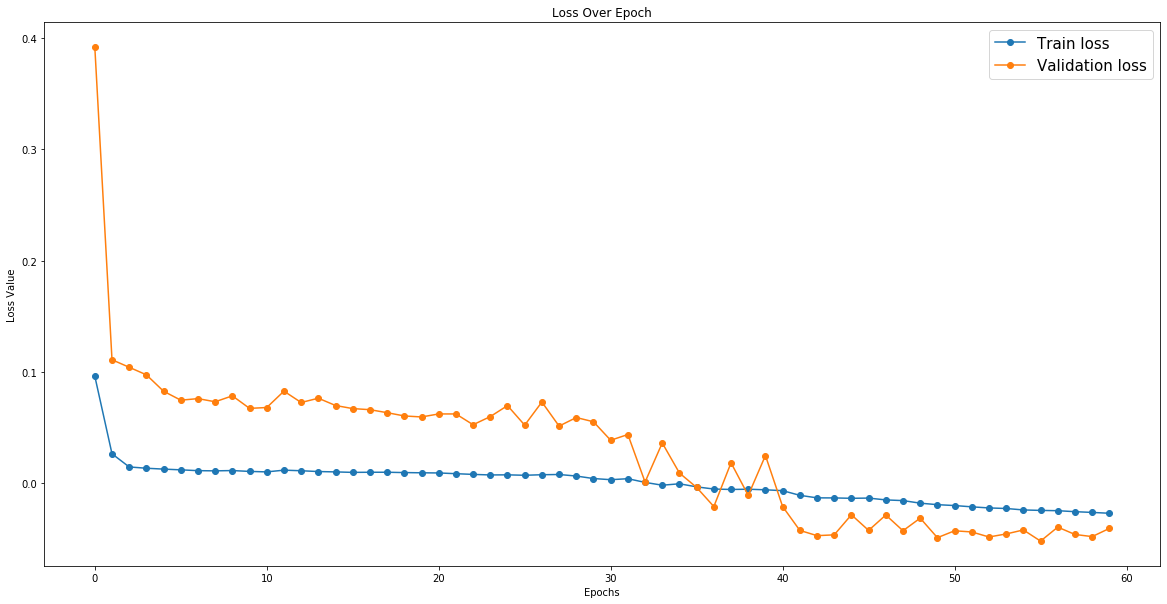

In [98]:
plt.figure(figsize=(20, 10))
plt.title('Loss Over Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
train_curve = plt.plot(history['train_loss'], marker = 'o', label = 'Train loss')
validation_curve = plt.plot(history['validation_loss'], marker = 'o', label = 'Validation loss')
plt.legend(fontsize = 15)
plt.show()

In [99]:
# Load the unet model at its prime (when it performed the best on the validation set).
state_dict = torch.load(os.path.join(model_save_path, 'Basic_Unet_best_model.pth'))
unet_model.load_state_dict(state_dict)

# Testing process on test data.
unet_model.eval()
# Getting test data indices for dataloading
test_data_indexes = test_indices
# Total testing data used.
data_length = len(test_data_indexes)
# Score after testing on dataset.
mean_test_score = 0

for batch, data in enumerate(testloader):
    # Data prepared to be given as input to model.
    image = data['image'].to(device, dtype=torch.float)
    mask = data['mask']

    # Predicted output from the input sample.
    mask_prediction = unet_model(image).cpu()
    # Threshold elimination.
    mask_prediction = (mask_prediction > 0.5)
    mask_prediction = mask_prediction.numpy()

    mask = np.resize(mask, (155, 240, 240))
    mask_prediction = np.resize(mask_prediction, (155, 240, 240))

    # Calculating the dice score for original and predicted mask.
    mean_test_score += dice_coefficient(mask_prediction, mask)

# Calculating the mean score for the whole test dataset.
unet_score = mean_test_score / data_length
# Putting the model back to training mode.
print(f'\nDice Score {unet_score}\n')


Dice Score 0.5200868951366857



In [82]:
def result(image, mask, output, title, transparency = 0.38, save_path = None):
    '''
    Plots a 2x3 plot with comparisons of output and original image.
    Works best with Jupyter Notebook/Lab.
    Parameters:
        image(numpy.ndarray): Array containing the original image of MRI scan.
        mask(numpy.ndarray): Array containing the original mask of tumor.
        output(numpy.ndarray): Model predicted mask from input image.
        title(str): Title of the plot to be used.
        transparency(float): Transparency level of mask on images.
                             Default: 0.38
        save_path(str): Saves the plot to the location specified.
                        Does nothing if None. 
                        Default: None
    Return:
        None
    '''

    fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(
        10, 8), gridspec_kw={'wspace': 0.025, 'hspace': 0.010})
    fig.suptitle(title, x=0.5, y=0.92, fontsize=20)

    axs[0][0].set_title("Original Mask", fontdict={'fontsize': 16})
    axs[0][0].imshow(mask, cmap='gray')
    axs[0][0].set_axis_off()

    axs[0][1].set_title("Predicted Mask", fontdict={'fontsize': 16})
    axs[0][1].imshow(output, cmap='gray')
    axs[0][1].set_axis_off()

    mask_diff = np.abs(np.subtract(mask, output))
    axs[0][2].set_title("Mask Difference", fontdict={'fontsize': 16})
    axs[0][2].imshow(mask_diff, cmap='gray')
    axs[0][2].set_axis_off()

    seg_output = mask*transparency
    seg_image = np.add(image, seg_output)/2
    axs[1][0].set_title("Original Segmentation", fontdict={'fontsize': 16})
    axs[1][0].imshow(seg_image, cmap='gray')
    axs[1][0].set_axis_off()
    
    seg_output = output*transparency
    seg_image = np.add(image, seg_output)/2
    axs[1][1].set_title("Predicted Segmentation", fontdict={'fontsize': 16})
    axs[1][1].imshow(seg_image, cmap='gray')
    axs[1][1].set_axis_off()

    axs[1][2].set_title("Original Input Image", fontdict={'fontsize': 16})
    axs[1][2].imshow(image, cmap='gray')
    axs[1][2].set_axis_off()

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi = 90, bbox_inches = 'tight')

    plt.show()

In [85]:
for example_index in range(5):
    # The purpose of image_index is to make sure we truly pick from the test set.
    image_index = test_indices[example_index]
    sample = tumor_dataset[image_index]
    threshold = 0.5

    unet_model.eval()
    image = sample['image'].numpy()
    mask = sample['mask'].numpy()

    image_tensor = torch.Tensor(image)
    image_tensor = image_tensor.view((-1, 155, 240, 240)).to(device)
    output = unet_model(image_tensor).detach().cpu()
    output = (output > threshold)
    output = output.numpy()

    # image(numpy.ndarray): 240x240 Original brain scanned image.
    image = image[75, :, :]
    # mask(numpy.ndarray): 240x240 Original mask of scanned image.
    mask = mask[75, :, :]
    # output(numpy.ndarray): 240x240 Generated mask of scanned image.
    output = output[75, :, :]
    # score(float): Sørensen–Dice Coefficient for mask and output. Calculates how similar are the two images.
    d_score = dice_coefficient(output, mask)

    title = f'Name: {image_index}.png   Dice Score: {d_score:.5f}'
    # save_path = os.path.join('images',f'{d_score:.5f}_{image_index}.png')
    result(image, mask, output, title, save_path = None)

IndexError: index 75 is out of bounds for axis 0 with size 1

## 3. Traditional Data Augmentation with TorchIO

In [5]:
import torchio
from torchio.transforms import Rescale, RandomAffine
from torchvision.transforms import Compose
from torch.utils.data import DataLoader

In [ ]:
# Some visualization functions

def show_nifti(image_path_or_image, colormap='gray'):
    try:
        from niwidgets import NiftiWidget
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=FutureWarning)
            widget = NiftiWidget(image_path_or_image)
            widget.nifti_plotter(colormap=colormap)
    except Exception:
        if isinstance(image_path_or_image, nib.AnalyzeImage):
            nii = image_path_or_image
        else:
            image_path = image_path_or_image
            nii = nib.load(str(image_path))
        k = int(nii.shape[-1] / 2)
        plt.imshow(nii.dataobj[..., k], cmap=colormap)

def show_sample(sample, image_name, label_name=None):
    if label_name is not None:
        sample = copy.deepcopy(sample)
        affine = sample[label_name][AFFINE]
        label = sample[label_name][DATA][0].numpy().astype(np.uint8)
        label_image = torchio.utils.nib_to_sitk(label, affine)
        border = sitk.BinaryContour(label_image)
        border_array, _ = torchio.utils.sitk_to_nib(border)
        border_tensor = torch.from_numpy(border_array)
        image_tensor = sample[image_name][DATA][0]
        image_tensor[border_tensor > 0.5] = image_tensor.max()
    with tempfile.NamedTemporaryFile(suffix='.nii') as f:
        torchio.ImagesDataset.save_sample(sample, {image_name: f.name})
        show_nifti(f.name)

def plot_histogram(axis, tensor, num_positions=100, label=None, alpha=0.05, color=None):
    values = tensor.numpy().ravel()
    kernel = stats.gaussian_kde(values)
    positions = np.linspace(values.min(), values.max(), num=num_positions)
    histogram = kernel(positions)
    kwargs = dict(linewidth=1, color='black' if color is None else color, alpha=alpha)
    if label is not None:
        kwargs['label'] = label
    axis.plot(positions, histogram, **kwargs)

In [6]:
dataPath = Path('./data')

t1_path = dataPath / 'all_gbm_pre_reg'
tumor_path = dataPath / 'all_tumors_reg'
brain_mask_path = dataPath / 'brain_masks'

t1_locations = sorted(t1_path.glob('*.nii.gz'))
tumor_locations = sorted(tumor_path.glob('*.nii.gz'))
brain_mask_locations = sorted(brain_mask_path.glob('*.nii.gz'))


assert len(t1_locations) == len(tumor_locations) == len(brain_mask_locations)

subjects = []
for (image_path, label_path, brain_mask_path) in zip(t1_locations, tumor_locations, brain_mask_locations):
    subject = torchio.Subject(
        torchio.Image('t1', image_path, torchio.INTENSITY),
        torchio.Image('tumor', label_path, torchio.LABEL),
        torchio.Image('brain mask', brain_mask_path, torchio.LABEL)
    )
    subjects.append(subject)
    
dataset = torchio.ImagesDataset(subjects)
print('Dataset size:', len(dataset), 'subjects')

Dataset size: 335 subjects


### 3.1 Exploration

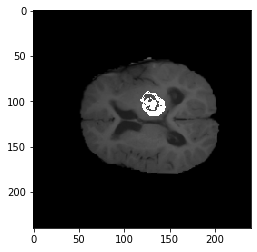

In [7]:
sample = dataset[0]
show_sample(sample, 't1', label_name='tumor')

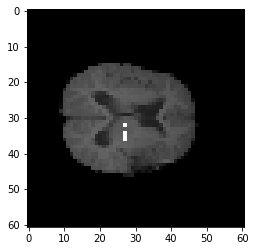

In [8]:
to_ras = torchio.transforms.ToCanonical()
# to_iso = torchio.transforms.Resample((4, 4, 4))
ras_iso_transform = Compose([to_ras, to_iso])
ras_iso_sample = ras_iso_transform(sample)
show_sample(ras_iso_sample, 't1', label_name='tumor')

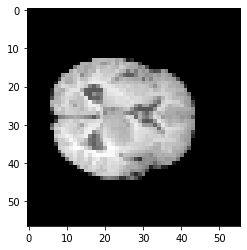

In [9]:
crop_transform = torchio.transforms.Crop(cropping=(2, 2, 3, 2, 0, 4))
transformed = crop_transform(ras_iso_sample)
show_sample(transformed, 't1')

In [10]:
ras_iso_crop_transform = Compose([ras_iso_transform, crop_transform])
nicer_dataset = torchio.ImagesDataset(subjects, transform=ras_iso_crop_transform)

In [13]:
len(nicer_dataset)

335

### 3.2 Processing

In [11]:
# Histogram standization

histogram_landmarks_path = 'landmarks.npy'

from torchio.transforms import HistogramStandardization
landmarks = HistogramStandardization.train(
    t1_locations,
    output_path=histogram_landmarks_path,
)
print(landmarks.shape)

100%|██████████| 335/335 [01:59<00:00,  2.81it/s]

(13,)


In [12]:
landmarks_dict = {'t1': landmarks}
histogram_transform = HistogramStandardization(landmarks_dict)

from torchio.transforms import ZNormalization
znorm_transform = ZNormalization(masking_method=ZNormalization.mean)

sample = dataset[0]
transform = Compose([histogram_transform, znorm_transform])
znormed = transform(sample)

### 3.3 Augmentation

#### 3.3.1 Intensity

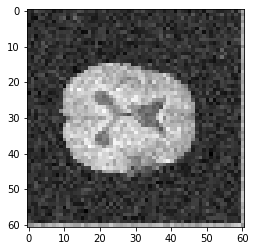

In [21]:
# Noise

noise_transform = torchio.transforms.RandomNoise(std_range=(0.5, 0.5), seed=seed)
znormed = ras_iso_transform(znormed)
show_sample(znormed, 't1')
transformed = noise_transform(znormed)
show_sample(transformed, 't1')

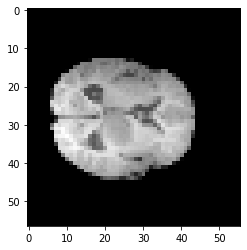

In [22]:
# Bias_field

bias_transform = torchio.transforms.RandomBiasField(proportion_to_augment=1, seed=seed)
sample = nicer_dataset[0]
show_sample(sample, 't1')
transformed = bias_transform(sample)
show_sample(transformed, 't1')

#### 3.3.2 Spatial

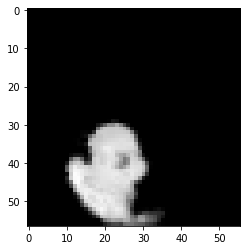

In [23]:
# NN
# Affine

transform = torchio.transforms.RandomAffine(degrees=(10, 15), seed=seed)
sample = nicer_dataset[0]
transformed = transform(sample)
show_sample(transformed, 't1')

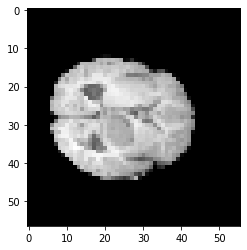

In [24]:
# Flip

transform = torchio.transforms.RandomFlip(axes=(2,), seed=0)
transformed = transform(nicer_dataset[0])
show_sample(transformed, 't1')

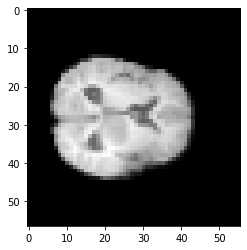

In [25]:
# Elastic

transform = torchio.transforms.RandomElasticDeformation(proportion_to_augment=1, seed=42)
sample = nicer_dataset[0]
show_sample(sample, 't1')
transformed = transform(sample)
show_sample(transformed, 't1')

#### 3.3.3 Train a network

In [27]:
# 0.8,0.1,0.1

from torchio.transforms import (
    RandomFlip, # check axis
    RandomAffine,
    RandomElasticDeformation,
    RandomNoise, # lower noise
    RandomMotion, # no use
    RandomBiasField,
    Rescale,
    Resample,
    ToCanonical,
    ZNormalization,
    CenterCropOrPad,
    HistogramStandardization,
)

training_transform = Compose([
    Rescale((0, 1)),  # so that there are no negative values for RandomMotion
    RandomMotion(),
    HistogramStandardization(landmarks_dict={'t1': landmarks}),
    RandomBiasField(),
    ZNormalization(masking_method=ZNormalization.mean),
    RandomNoise(),
    ToCanonical(),
    Resample((4, 4, 4)),
    CenterCropOrPad((48, 60, 48)),
    RandomFlip(axes=(0,)),
    RandomAffine(),
    RandomElasticDeformation(proportion_to_augment=0.1),
])

validation_transform = Compose([
    HistogramStandardization(landmarks_dict={'t1': landmarks}),
    ZNormalization(masking_method=ZNormalization.mean),
    ToCanonical(),
    Resample((4, 4, 4)),
    CenterCropOrPad((48, 60, 48)),
])

num_subjects = len(dataset)
num_training_subjects = int(training_split_ratio * num_subjects)

training_subjects = subjects[:num_training_subjects]
validation_subjects = subjects[num_training_subjects:]

training_set = torchio.ImagesDataset(
    training_subjects, transform=training_transform)

validation_set = torchio.ImagesDataset(
    validation_subjects, transform=validation_transform)

print('Training set:', len(training_set), 'subjects')
print('Validation set:', len(validation_set), 'subjects')

Training set: 301 subjects
Validation set: 34 subjects


In [33]:
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
CHANNELS_DIMENSION = 1
SPATIAL_DIMENSIONS = 2, 3, 4

class Action(enum.Enum):
    TRAIN = 'Training'
    VALIDATE = 'Validation'

def prepare_batch(batch, device):
    inputs = batch['t1'][DATA].to(device)
    foreground = batch['tumor'][DATA].to(device)
    background = 1 - foreground
    targets = torch.cat((background, foreground), dim=CHANNELS_DIMENSION)
    return inputs, targets

def get_dice_score(output, target, epsilon=1e-9):
    p0 = output
    g0 = target
    p1 = 1 - p0
    g1 = 1 - g0
    tp = (p0 * g0).sum(dim=SPATIAL_DIMENSIONS)
    fp = (p0 * g1).sum(dim=SPATIAL_DIMENSIONS)
    fn = (p1 * g0).sum(dim=SPATIAL_DIMENSIONS)
    num = 2 * tp
    denom = 2 * tp + fp + fn + epsilon
    dice_score = num / denom
    return dice_score

def get_dice_loss(output, target):
    return 1 - get_dice_score(output, target)

def forward(model, inputs):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        logits = model(inputs)
    return logits

def get_model_and_optimizer(device):
    # Use pytorch, next step
    # 1. use baseline data to train unet, if poor, change unet
    # 2. data augmentation
    model = UNet(
        in_channels=1,
        out_classes=2,
        dimensions=3,
        num_encoding_blocks=3,
        out_channels_first_layer=8,
        normalization='batch',
        upsampling_type='linear',
        padding=True,
        padding_mode='reflection',
        activation='PReLU',
    ).to(device)
    optimizer = torch.optim.AdamW(model.parameters())
    return model, optimizer

def run_epoch(epoch_idx, action, loader, model, optimizer):
    is_training = action == Action.TRAIN
    epoch_losses = []
    model.train(is_training)
    for batch_idx, batch in enumerate(tqdm(loader)):
        inputs, targets = prepare_batch(batch, device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(is_training):
            logits = forward(model, inputs)
            probabilities = F.softmax(logits, dim=CHANNELS_DIMENSION)
            batch_losses = get_dice_loss(probabilities, targets)
            batch_loss = batch_losses.mean()
            if is_training:
                batch_loss.backward()
                optimizer.step()
            epoch_losses.append(batch_loss.item())
    epoch_losses = np.array(epoch_losses)
    print(f'{action.value} mean loss: {epoch_losses.mean():0.3f}')

def train(num_epochs, training_loader, validation_loader, model, optimizer, weights_stem):
    run_epoch(0, Action.VALIDATE, validation_loader, model, optimizer)
    for epoch_idx in range(1, num_epochs + 1):
        print('Starting epoch', epoch_idx)
        run_epoch(epoch_idx, Action.TRAIN, training_loader, model, optimizer)
        run_epoch(epoch_idx, Action.VALIDATE, validation_loader, model, optimizer)
        torch.save(model.state_dict(), f'{weights_stem}_epoch_{epoch_idx}.pth')

In [29]:
training_batch_size = 16
validation_batch_size = 2 * training_batch_size

training_loader = torch.utils.data.DataLoader(
    training_set,
    batch_size=training_batch_size,
    shuffle=True,
    num_workers=multiprocessing.cpu_count(),
)

validation_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size=validation_batch_size,
    num_workers=multiprocessing.cpu_count(),
)

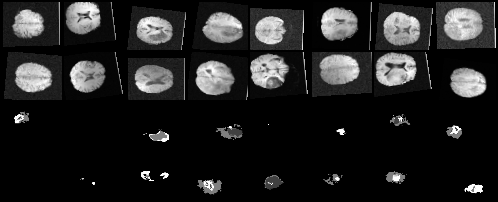

In [30]:
one_batch = next(iter(training_loader))

k = 24
batch_t1 = one_batch['t1'][DATA][..., k]
batch_tumor = one_batch['tumor'][DATA][..., k]
slices = torch.cat((batch_t1, batch_tumor))
image_path = 'batch_whole_images.png'
save_image(slices, image_path, nrow=training_batch_size//2, normalize=True, scale_each=True)
display.Image(image_path)

In [34]:
# Train, wait for local server or GPU available

model, optimizer = get_model_and_optimizer(device)

weights_stem = 'whole_images'
train(num_epochs, training_loader, validation_loader, model, optimizer, weights_stem)


Validation mean loss: 0.610
Starting epoch 1


RuntimeError: [enforce fail at CPUAllocator.cpp:64] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 3822059520 bytes. Error code 12 (Cannot allocate memory)


# 4. Data Augmentation with GAN